<a href="https://colab.research.google.com/github/sidvin101/explainable-ml/blob/main/explainableai_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #05
### This is Assignment 5 of Duke's AIPI590 course. It involves an implementation of LIME on image data using a pretrained model (ResNet34)
### Siddarth Vinnakota






## DO:
* Use markdown and comments effectively
* Pull out classes and functions into scripts
* Ensure cells are executed in order and avoid skipping cells to maintain reproducibility
* Choose the appropriate runtime (i.e. GPU) if needed
* If you are using a dataset that is too large to put in your GitHub repository, you must either pull it in via Hugging Face Datasets or put it in an S3 bucket and use boto3 to pull from there.
* Use versioning on all installs (ie pandas==1.3.0) to ensure consistency across versions
* Implement error handling where appropriate

## DON'T:
* Absolutely NO sending us Google Drive links or zip files with data (see above).
* Load packages throughout the notebook. Please load all packages in the first code cell in your notebook.
* Add API keys or tokens directly to your notebook!!!! EVER!!!
* Include cells that you used for testing or debugging. Delete these before submission
* Have errors rendered in your notebook. Fix errors prior to submission.

In [1]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "explainable-ml" # Change to your repo name
git_path = 'https://github.com/sidvin101/explainable-ml.git' #Change to your path
!git clone "{git_path}"


rm: cannot remove './sample_data': No such file or directory
fatal: destination path 'explainable-ml' already exists and is not an empty directory.


# LIME

For this assignment, I used LIME. LIME, aka Local Interpretable Model-Agnostic Explanations, is a model used to explain the predictions of a model. In short, an instance is selected, and the image is perturbed, receiving the black box model for each sample. An interpretable model is then trained, using the weights of the samples. What you will see in the bottom assignment is that the highlighted parts of the image are the main part of the image for identifying what the image is. I chose this method as it was an easy and intuitive method to explain, and it works very well for images.

This model is extremely flexible, and as shown in this demo it is able to be used on image data as well as text. However, it is prone to instabilities and biases in explanations, since much of this is based on their own model training, and such biases are very inherent.

Further improvements will need to be made to reduce these biases. An example would be through feature selection. For example, in the below explanation of the Bernese mountain dog, only the nose is highlighted, but the model could also be biased towards the color. So, further testing to test these features would be important, such as removing all color from the image so the model cannot rely on it.

In [2]:
pip install lime

In [3]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import json
import requests

In [4]:
#Load the ResNet34 Model
model = models.resnet34(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
#We need to set a tranformation criteria do we can transform the image so it can be usable
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
#This function loads and preprocess
def load_image(image_path):
    img = Image.open(image_path)  # Load the image
    img_preprocessed = preprocess(img).unsqueeze(0)  # Apply preprocessing and add batch dimension
    return img, img_preprocessed

image_path = '/content/dog.jpg'
original_img, img_preprocessed = load_image(image_path)

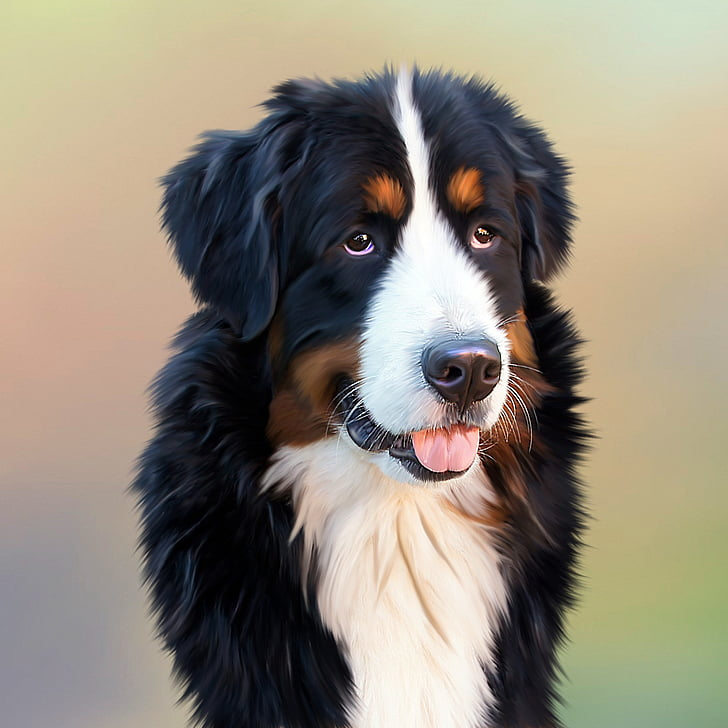

In [7]:
original_img

In [8]:
img_preprocessed

tensor([[[[1.5297, 1.5297, 1.5297,  ..., 1.4783, 1.4954, 1.5125],
          [1.5125, 1.5125, 1.5125,  ..., 1.5639, 1.5639, 1.5468],
          [1.5125, 1.4954, 1.4954,  ..., 1.5468, 1.5468, 1.5297],
          ...,
          [0.3481, 0.3652, 0.3652,  ..., 0.5022, 0.5022, 0.5022],
          [0.3481, 0.3652, 0.3652,  ..., 0.5022, 0.5022, 0.5022],
          [0.3481, 0.3481, 0.3481,  ..., 0.5022, 0.5022, 0.4851]],

         [[1.6057, 1.6232, 1.6232,  ..., 1.8508, 1.8333, 1.8333],
          [1.6057, 1.5882, 1.5882,  ..., 1.8158, 1.8158, 1.8158],
          [1.6057, 1.5707, 1.5707,  ..., 1.7983, 1.7983, 1.7808],
          ...,
          [0.4678, 0.4503, 0.4503,  ..., 1.0105, 1.0105, 1.0105],
          [0.4678, 0.4503, 0.4503,  ..., 1.0105, 1.0105, 1.0105],
          [0.4678, 0.4678, 0.4678,  ..., 1.0105, 1.0105, 0.9930]],

         [[1.0888, 1.0539, 1.0539,  ..., 1.6814, 1.6814, 1.6814],
          [1.0365, 1.0714, 1.0714,  ..., 1.6814, 1.6814, 1.6814],
          [1.0365, 1.0539, 1.0539,  ..., 1

In [9]:
#Get the labels for imagenet
def get_imagenet_labels():
    labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
    response = requests.get(labels_url)
    return json.loads(response.text)

imagenet_labels = get_imagenet_labels()

In [10]:
imagenet_labels[1:10]

['goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead shark',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich']

In [11]:
#Create the prediction function
def predict(img_preprocessed):
    with torch.no_grad():
        output = model(img_preprocessed)
        probabilities = torch.nn.functional.softmax(output, dim=1)
    return probabilities.numpy()

#Get the top predictions
def get_top_prediction(img_preprocessed):
    probs = predict(img_preprocessed)
    top_idx = np.argmax(probs)
    top_label = imagenet_labels[top_idx]
    top_prob = probs[0][top_idx]
    return top_label, top_prob

In [12]:
get_top_prediction(img_preprocessed)

('Bernese Mountain Dog', 0.82282346)

In [13]:
#Create an explainer using LIME
explainer = lime_image.LimeImageExplainer()

In [14]:
#Create the LIME explanation function
def batch_predict(images):
        batch = torch.stack([preprocess(Image.fromarray(image)) for image in images], dim=0)
        batch = batch.to(torch.device('cpu'))
        model.eval()
        with torch.no_grad():
            preds = model(batch)
        return torch.nn.functional.softmax(preds, dim=1).numpy()

In [15]:
#Create a function for explanation
def explain_image(model, image):
    #Creates the explanation
    explainer = lime_image.LimeImageExplainer()

    # Define a function to use in LIME
    def batch_predict(images):
        batch = torch.stack([preprocess(Image.fromarray(image)) for image in images], dim=0)
        batch = batch.to(torch.device('cpu'))
        model.eval()
        with torch.no_grad():
            preds = model(batch)
        return torch.nn.functional.softmax(preds, dim=1).numpy()

    # Explanation
    explanation = explainer.explain_instance(np.array(image),
                                             batch_predict,
                                             top_labels=5,
                                             hide_color=0,
                                             num_samples=1000)

    return explanation

In [16]:
explanation = explain_image(model, original_img)
explanation

  0%|          | 0/1000 [00:00<?, ?it/s]

In [17]:
top_class = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(top_class, positive_only=True, num_features=5, hide_rest=True)

('Bernese Mountain Dog', 0.82282346)


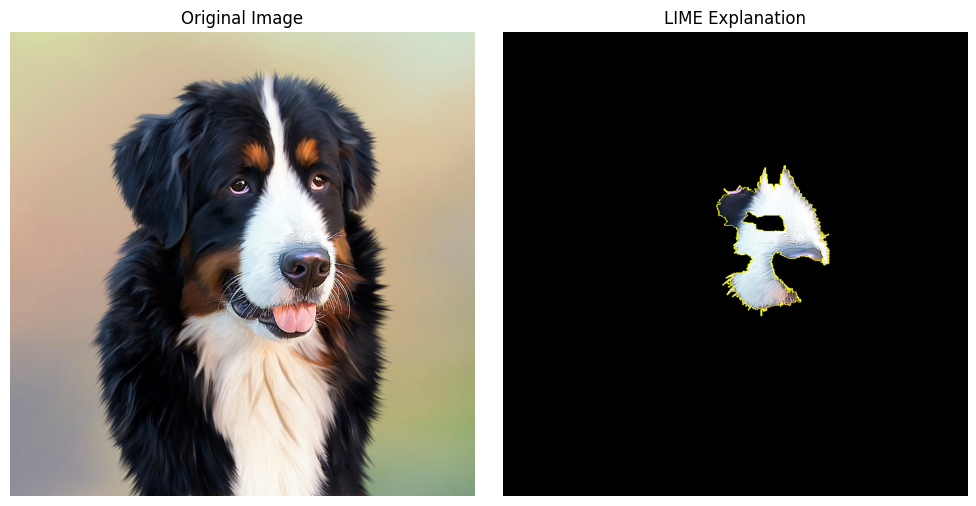

In [18]:
print(get_top_prediction(img_preprocessed))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

#Original Image
ax[0].imshow(original_img)
ax[0].axis('off')
ax[0].set_title('Original Image')

# Explanation image with important features highlighted and rest grayed out
ax[1].imshow(mark_boundaries(temp / 255.0, mask))
ax[1].axis('off')
ax[1].set_title('LIME Explanation')

plt.tight_layout()
plt.show()

As shown in the above, the highlighted chunk is what the model uses to classify that it's Bernese Mountain Dog. Very interesting, as it was just the nose and the colors. As a result, we know how this model does what it does.

